### Install and import libraries

In [ ]:
!pip install pandas_ta
!pip install transformers
!pip install tqdm
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=3c5040f34afad5e9353da89d4cf8d6c5193161a7223e37616bdc6a7cbf86337d
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 19.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.

In [ ]:
import numpy as np
import pandas as pd
import pandas_ta as ta
from functools import reduce
from datetime import datetime, timedelta
import yfinance as yf

import urllib
import json

import torch
from tqdm import tqdm

use_cuda = True

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

### Choose the stock ticker

In [ ]:
###### Set the dates ############
start = datetime(2017,1,1)
end = datetime(2023,7,31)

######## Set the ticker ##########
ticker_yf = 'TSLA' ############ change here

# other automotive stocks :  'GM', 'F', 'TSLA', 'TM'

- this notebook tests different combination of data
- It uses price&fundamental data as a base data, and can experiment with effects of adding different data(news sentiment and technical)
- run section A first, and you can try different combinations (A only, A+B, A+C, A+B+C)
- after choosing the combination of the data, go to section D and run the cell. It will print out the results for different periods of returns as labels

### A. Download Price data and Fundamental Data and then combine them

In [ ]:
# Get the price data from yfinance
price_df = yf.download(ticker_yf, start, end)
price_df = price_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
price_df.rename(columns = {'Adj Close' : 'Close'}, inplace = True)

print(price_df.shape)

[*********************100%***********************]  1 of 1 completed
(1653, 5)


<ipython-input-5-8218e7fc8bc8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df.rename(columns = {'Adj Close' : 'Close'}, inplace = True)


In [ ]:
# Get fundamental data from EOD historical data

ticker_eod = ticker_yf + '.US'
api_key = '64b2f4a3d12634.87203740'

url = 'https://eodhistoricaldata.com/api/fundamentals/' + ticker_eod + '?api_token=' +api_key

response = urllib.request.urlopen(url)
data = json.loads(response.read())


# dates for for loop
quarter_list = list(data['Financials']['Balance_Sheet']['quarterly'].keys())[:50]

# create empty frame
fundamental_df = pd.DataFrame(index= quarter_list)

# extract data
date_list = []
shares_list = []
for i in range(50):
  # date_list.append(data['outstandingShares']['quarterly'][str(i)]['dateFormatted'])
  shares_list.append(data['outstandingShares']['quarterly'][str(i)]['shares'])
fundamental_df['outstandingShares'] = shares_list

epsActual = []

for date in quarter_list:
 epsActual.append(data['Earnings']['History'][date]['epsActual'])
fundamental_df['epsActual'] = epsActual

##############
# EV = Market Cap + Total Debt – Cash

totalAssets = []
totalStockholderEquity = []
shortLongTermDebtTotal = []
cashAndEquivalents = []

for date in quarter_list:
  totalAssets.append(data['Financials']['Balance_Sheet']['quarterly'][date]['totalAssets'])
  totalStockholderEquity.append(data['Financials']['Balance_Sheet']['quarterly'][date]['totalStockholderEquity'])
  shortLongTermDebtTotal.append(data['Financials']['Balance_Sheet']['quarterly'][date]['shortLongTermDebtTotal'])

  ######## modified
  if data['Financials']['Balance_Sheet']['quarterly'][date]['cashAndEquivalents'] is None:
    cashAndEquivalents.append(data['Financials']['Balance_Sheet']['quarterly'][date]['cash'])
  else:
    cashAndEquivalents.append(data['Financials']['Balance_Sheet']['quarterly'][date]['cashAndEquivalents'])

fundamental_df['totalAssets'] = totalAssets
fundamental_df['totalStockholderEquity'] = totalStockholderEquity
fundamental_df['shortLongTermDebtTotal'] = shortLongTermDebtTotal
fundamental_df['cashAndEquivalents'] = cashAndEquivalents ##


#########

netIncome = []
ebitda = []

for date in quarter_list:
  netIncome.append(data['Financials']['Income_Statement']['quarterly'][date]['netIncome'])
  ebitda.append(data['Financials']['Income_Statement']['quarterly'][date]['ebitda'])

fundamental_df['netIncome'] = netIncome
fundamental_df['ebitda'] = ebitda


# making datetime index
fundamental_df.index = pd.to_datetime(fundamental_df.index)

# to_numeric
for column in fundamental_df.columns:
  fundamental_df[column] = pd.to_numeric(fundamental_df[column])

# Create roe, roa, ev/ebitda, p/e, debt/asset

# merge price and fundamentals --> then ffill
merged_df = pd.merge(price_df, fundamental_df, how='left', right_index=True, left_index=True)
merged_df = merged_df.fillna(method='ffill').dropna()

# making fundamentals

merged_df['roe'] = merged_df['netIncome'] / merged_df['totalStockholderEquity']
merged_df['roa'] = merged_df['netIncome'] / merged_df['totalAssets']
merged_df['debt/asset'] = merged_df['shortLongTermDebtTotal'] / merged_df['totalAssets']
merged_df['p/e'] = merged_df['Close'] / merged_df['epsActual']
merged_df['ev'] = merged_df['Close'] * merged_df['outstandingShares'] + merged_df['shortLongTermDebtTotal'] - merged_df['cashAndEquivalents']
merged_df['ev/ebitda'] = merged_df['ev'] / merged_df['ebitda']

# choosing only the necessary columns
final_df = merged_df[['Open', 'High', 'Low', 'Close', 'Volume', 'roe', 'roa', 'debt/asset', 'ev/ebitda', 'p/e']]

print(final_df.shape)

(1592, 10)


### B. Gather financial news data from EOD

##### Load pre-processed news and sentiment csv file

- Since it takes a long time to download the news and use FIN-BERT to make sentiment analysis, we have downloaded the news and conducted sentiment analysis and saved it into csv files.

- You can either use the pre-processed csv file, or if not, uncomment the cells below (marked as 2-1 & 2-2) and run the cell

In [ ]:
gdrive_path = 'data/'+ticker_yf + 'newstotal.csv'   ####### path for the csv file

news_df = pd.read_csv(gdrive_path, index_col=0)
news_df.reset_index(drop=True, inplace=True)
news_df = news_df.loc[:, ~news_df.columns.str.contains('^Unnamed')]

print(news_df.shape)
news_df.head()

(24401, 6)


,date,text,pos_eod,neu_eod,neg_eod,score
0,2018-01-03,Tesla Q4 2017 Vehicle Production and Deliverie...,0.101,0.887,0.012,0.089
1,2018-01-23,Tesla Announces New Long-Term Performance Awar...,0.153,0.832,0.016,0.137
2,2018-02-05,"Recent Analysis Shows Allegiant Travel, Green,...",0.064,0.928,0.008,0.056
3,2018-02-07,Tesla Releases Fourth Quarter and Full Year 20...,0.020,0.980,0.000,0.020
4,2018-04-03,Tesla Q1 2018 Vehicle Production and Deliverie...,0.098,0.877,0.024,0.074


##### 2-1. Downloading the news from the API.

- Uncomment and run the cell if you decided not to load pre-processed csv file

In [ ]:
# ############### DON'T RUN THIS SELL IF YOU RAN THE CELL ABOVE.
# ############### THIS WILL TAKE A LONG TIME

# ### Scrapping financial news and making it into a df

# ## set the dates
# news_date_list = pd.date_range(start=str(start.date()), end=str(end.date()))

# # scrap the news into a df
# news_df = pd.DataFrame(columns = ['date', 'text', 'pos_eod', 'neu_eod', 'neg_eod'] )

# for i in range(len(news_date_list) - 1):
#   tmp_start = news_date_list[i]
#   news_url = 'https://eodhistoricaldata.com/api/news?api_token='+api_key+'&s='+ticker_eod + '&limit=50&from=' + str(tmp_start.date()) + '&to=' + tmp_start.strftime('%Y-%m-%d')

#   news_response = urllib.request.urlopen(news_url)
#   news_data = json.loads(news_response.read())

#   if len(news_data) ==0:
#     pass

#   else:

#     tmp_df = pd.DataFrame()
#     date_list = []
#     text_list = []
#     pos_eod_list = []
#     neu_eod_list = []
#     neg_eod_list = []

#     news_date = news_data[0]['date'].split('T')[0]
#     # print(news_date)
#     for n in range(len(news_data)):
#       date_list.append(news_date)
#       text_list.append(news_data[n]['title'] +'. ' +  news_data[n]['content'])

#       if news_data[n]['sentiment'] is not None:

#         if news_data[n]['sentiment']['pos'] is not None:
#           pos_eod_list.append(news_data[n]['sentiment']['pos'])
#         else:
#           pos_eod_list.append(0)

#         if news_data[n]['sentiment']['neu'] is not None:
#           neu_eod_list.append(news_data[n]['sentiment']['neu'])
#         else:
#           neu_eod_list.append(0)

#         if news_data[n]['sentiment']['neg'] is not None:
#           neg_eod_list.append(news_data[n]['sentiment']['neg'])
#         else:
#           neg_eod_list.append(0)

#       else:
#         pos_eod_list.append(0)
#         neu_eod_list.append(1)
#         neg_eod_list.append(0)

#     tmp_df['date'] = date_list
#     tmp_df['text'] = text_list
#     tmp_df['pos_eod'] = pos_eod_list
#     tmp_df['neu_eod'] = neu_eod_list
#     tmp_df['neg_eod'] = neg_eod_list

#     news_df = pd.concat([news_df, tmp_df])

# news_df = news_df.reset_index()
# news_df = news_df[['date', 'text', 'pos_eod', 'neu_eod', 'neg_eod']]
# news_df = news_df.drop_duplicates()
# news_df['score'] = news_df['pos_eod'] - news_df['neg_eod']
# print(news_df.shape)

(6669, 6)


##### 2-2. Using FIN-BERT to make sentiment analysis

- Uncomment and run the cell if you decided not to load pre-processed csv file
- THE NEXT CELL WILL TAKE MORE THAN 24 HOURS(2017~2013)

In [ ]:
# #### THIS WILL TAKE MORE THAN 24 HOURS(2017~2013) ####
# #### DON'T RUN THIS. INSTEAD, WE WILL USE SENTIMENT ANALYSIS PROVIDED BY EOD API

# ####### SENTIMENT ANALYSIS WITH FIN-BERT ##########

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# import torch

# ###### Downloading FIN-BERT
# ### create a tokenizer object
# tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
# ### fetch the pretrained model
# model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# #### define sentiment analyzer

# def sentim_analyzer(value):

#   # Pre-process input phrase
#   input = tokenizer(value, padding = True, truncation = True, return_tensors='pt')
#   # Run inference on the tokenized phrase
#   output = model(**input)

#   # Pass model output logits through a softmax layer.
#   sentim_scores = torch.nn.functional.softmax(output.logits, dim=-1)

#   return round(sentim_scores[0][0].item(),4), round(sentim_scores[0][1].item(),4), round(sentim_scores[0][2].item(),4)


# pos_list = []
# neu_list = []
# neg_list = []

# for text in tqdm(news_df['text'][18619:25000]):
#   pos_list.append(sentim_analyzer(text)[0])
#   neu_list.append(sentim_analyzer(text)[1])
#   neg_list.append(sentim_analyzer(text)[2])

# news_df['pos'] = pos_list
# news_df['neu'] = neu_list
# news_df['neg'] = neg_list

# news_df['score'] = news_df['pos'] - news_df['neg']

##### This cell will combine sentiment score with fundamental data

- Run this cell whether you used pre-processed csv file or downloaded & FIN-BERTED the news yourself

In [ ]:
## COMBINING FUNDAMENTAL DATA AND SENTIMENT DATA

sentiment_df = news_df.groupby('date').agg({'score' : 'mean'}).round(4)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

final_df = pd.merge(final_df, sentiment_df, how='left',  right_index=True, left_index=True)
final_df = final_df.fillna(method='ffill').dropna()

final_df.head()

,Open,High,Low,Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e,score
Date,,,,,,,,,,,
2018-01-03,21.400000,21.683332,21.036667,21.150000,67822500,-0.065886,-0.012917,0.366515,526.888440,-234.999996,0.089
2018-01-04,20.858000,21.236668,20.378668,20.974667,149194500,-0.065886,-0.012917,0.366515,523.003087,-233.051851,0.089
2018-01-05,21.108000,21.149332,20.799999,21.105333,68868000,-0.065886,-0.012917,0.366515,525.898642,-234.503704,0.089
2018-01-08,21.066668,22.468000,21.033333,22.427334,147891000,-0.065886,-0.012917,0.366515,555.193971,-249.192598,0.089
2018-01-09,22.344000,22.586666,21.826668,22.246000,107199000,-0.065886,-0.012917,0.366515,551.175647,-247.177781,0.089


### C. Adding techinal indicators

In [ ]:
## COMBINING TECHINICAL DATA

def append_tech_indicators(df):

  df.ta.sma(append=True)
  df.ta.ema(append=True)
  df.ta.bbands(append=True)
  df.ta.vwma(append=True)
  df.ta.macd(append=True)
  df.ta.ao(append=True)

  return df.dropna()

final_df = append_tech_indicators(final_df)
final_df.head()

,Open,High,Low,Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VWMA_10,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,AO_5_34
Date,,,,,,,,,,,,,,,,,,,,,
2018-02-21,22.402000,22.646000,22.211332,22.219999,48294000,-0.065886,-0.012917,0.366515,550.599470,-246.888881,...,21.480090,22.132533,22.784977,5.895788,0.567030,21.618851,-0.149791,0.067327,-0.217118,-0.244886
2018-02-22,22.368668,23.162666,22.316668,23.077999,104547000,-0.065886,-0.012917,0.366515,569.612614,-256.422212,...,21.815886,22.450666,23.085447,5.654891,0.994134,21.627393,-0.060371,0.125397,-0.185769,-0.035465
2018-02-23,23.188667,23.666000,23.139999,23.469999,87261000,-0.065886,-0.012917,0.366515,578.299278,-260.777770,...,21.701177,22.690400,23.679622,8.719306,0.894047,21.914887,0.041645,0.181931,-0.140286,0.192002
2018-02-26,23.566668,23.933332,23.490667,23.827999,65100000,-0.065886,-0.012917,0.366515,586.232499,-264.755546,...,21.722764,22.982800,24.242835,10.965027,0.835387,22.390399,0.149656,0.231954,-0.082298,0.355492
2018-02-27,23.750000,23.999332,23.334000,23.399332,71961000,-0.065886,-0.012917,0.366515,576.733303,-259.992578,...,22.110104,23.199066,24.288027,9.387979,0.591953,22.658507,0.198379,0.224541,-0.026162,0.550206


### D. Run Pycaret for regression modeling with different return periods




******************************
******************************
******************************
Modeling with  1 - Day Return


,Description,Value
0,Session id,42
1,Target,log_return
2,Target type,Regression
3,Original data shape,"(1331, 20)"
4,Transformed data shape,"(1331, 20)"
5,Transformed train set shape,"(931, 20)"
6,Transformed test set shape,"(400, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,0.0299,0.0020,0.0435,-0.0149,0.0400,1.1211,0.0300
huber,Huber Regressor,0.0299,0.0020,0.0435,-0.0154,0.0393,1.2095,0.0450
llar,Lasso Least Angle Regression,0.0298,0.0020,0.0436,-0.0174,0.0395,1.1849,0.0450
omp,Orthogonal Matching Pursuit,0.0298,0.0020,0.0436,-0.0174,0.0395,1.1849,0.0350
lasso,Lasso Regression,0.0298,0.0020,0.0436,-0.0174,0.0395,1.1849,0.0350
en,Elastic Net,0.0299,0.0020,0.0436,-0.0178,0.0392,1.2202,0.0400
knn,K Neighbors Regressor,0.0340,0.0022,0.0468,-0.1997,0.0355,2.5654,0.0450
lightgbm,Light Gradient Boosting Machine,0.0407,0.0029,0.0531,-0.5076,0.0332,3.9091,1.2700
et,Extra Trees Regressor,0.0427,0.0032,0.0552,-0.6298,0.0323,3.8374,0.3050
par,Passive Aggressive Regressor,0.0431,0.0035,0.0565,-0.6569,0.0323,4.6131,0.0450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Dummy Regressor,0.0293,0.0016,0.0396,-0.0082,0.0361,1.1060


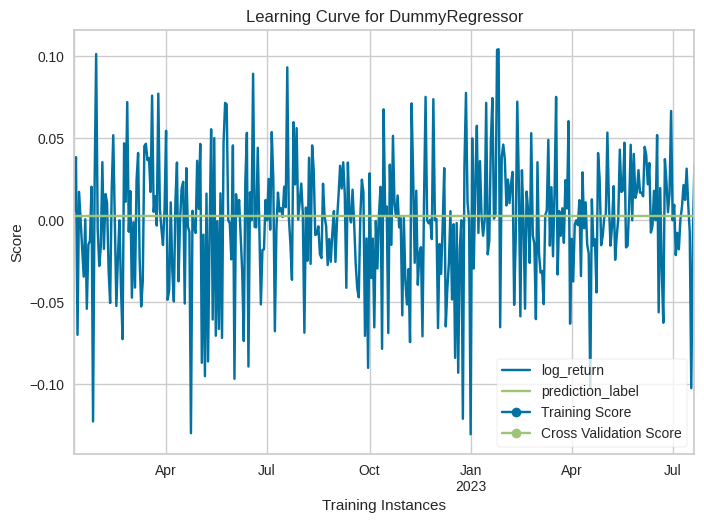




******************************
******************************
******************************
Modeling with  5 - Day Return


,Description,Value
0,Session id,42
1,Target,log_return
2,Target type,Regression
3,Original data shape,"(1326, 20)"
4,Transformed data shape,"(1326, 20)"
5,Transformed train set shape,"(928, 20)"
6,Transformed test set shape,"(398, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0446,0.0039,0.0609,0.6195,0.0481,3.4544,0.2700
lightgbm,Light Gradient Boosting Machine,0.0459,0.0042,0.0626,0.6006,0.0494,4.0496,1.5900
ada,AdaBoost Regressor,0.0469,0.0042,0.0636,0.5798,0.0494,5.7412,0.1650
rf,Random Forest Regressor,0.0496,0.0045,0.0653,0.5619,0.0497,3.1553,0.3900
gbr,Gradient Boosting Regressor,0.0715,0.0084,0.0875,0.2344,0.0577,5.9399,0.3150
xgboost,Extreme Gradient Boosting,0.0730,0.0087,0.0895,0.1923,0.0620,12.9292,0.2050
dt,Decision Tree Regressor,0.0664,0.0083,0.0910,0.0067,0.0625,8.0529,0.0400
dummy,Dummy Regressor,0.0754,0.0111,0.1023,-0.0699,0.0848,3.2356,0.0350
llar,Lasso Least Angle Regression,0.0759,0.0112,0.1028,-0.0782,0.0817,5.0300,0.0400
lasso,Lasso Regression,0.0759,0.0112,0.1028,-0.0782,0.0817,5.0300,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0421,0.0029,0.0541,0.6274,0.0421,12.7182


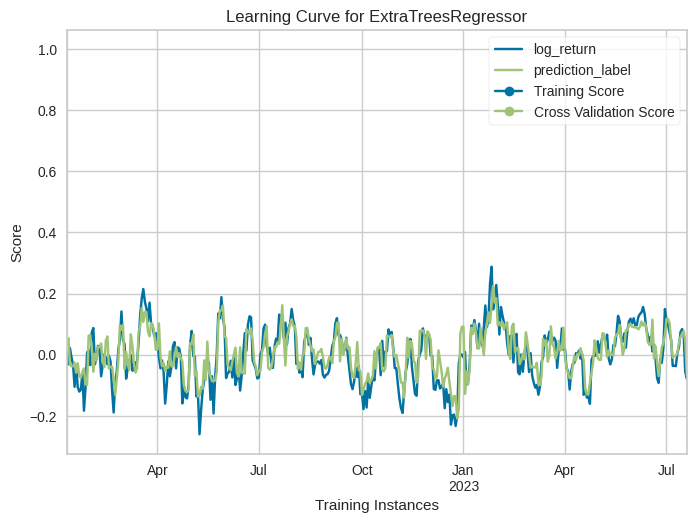

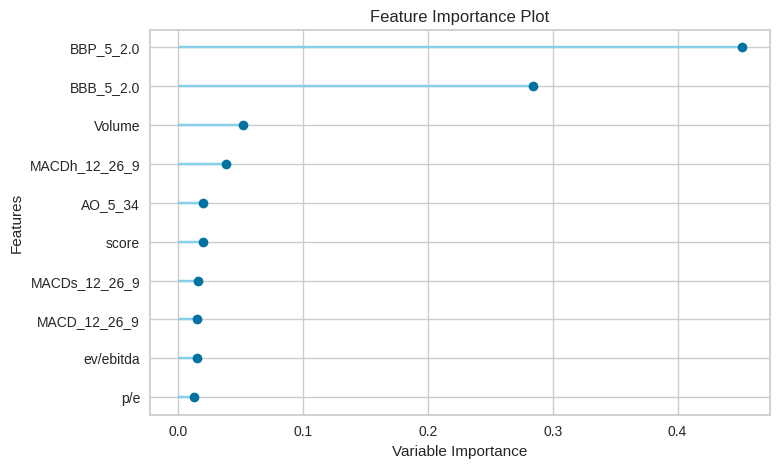




******************************
******************************
******************************
Modeling with  20 - Day Return


,Description,Value
0,Session id,42
1,Target,log_return
2,Target type,Regression
3,Original data shape,"(1306, 20)"
4,Transformed data shape,"(1306, 20)"
5,Transformed train set shape,"(914, 20)"
6,Transformed test set shape,"(392, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1215,0.0266,0.1626,0.2988,0.1191,20.6021,0.2800
ada,AdaBoost Regressor,0.1294,0.0286,0.1689,0.2290,0.1263,14.9090,0.1700
lightgbm,Light Gradient Boosting Machine,0.1340,0.0305,0.1739,0.2040,0.1308,15.7540,1.7600
xgboost,Extreme Gradient Boosting,0.1384,0.0327,0.1805,0.0555,0.1346,19.2568,0.2050
gbr,Gradient Boosting Regressor,0.1509,0.0395,0.1975,-0.0105,0.1489,17.5059,0.3050
en,Elastic Net,0.1683,0.0528,0.2090,-0.0644,0.1409,22.0737,0.0350
dummy,Dummy Regressor,0.1793,0.0555,0.2265,-0.2491,0.1632,8.0232,0.0450
omp,Orthogonal Matching Pursuit,0.1870,0.0596,0.2338,-0.3280,0.1646,2.4300,0.0400
rf,Random Forest Regressor,0.1611,0.0441,0.2070,-0.3839,0.1520,20.5210,0.3550
knn,K Neighbors Regressor,0.1912,0.0620,0.2399,-0.4029,0.1572,6.7755,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0750,0.0093,0.0964,0.7946,0.0722,1.8964


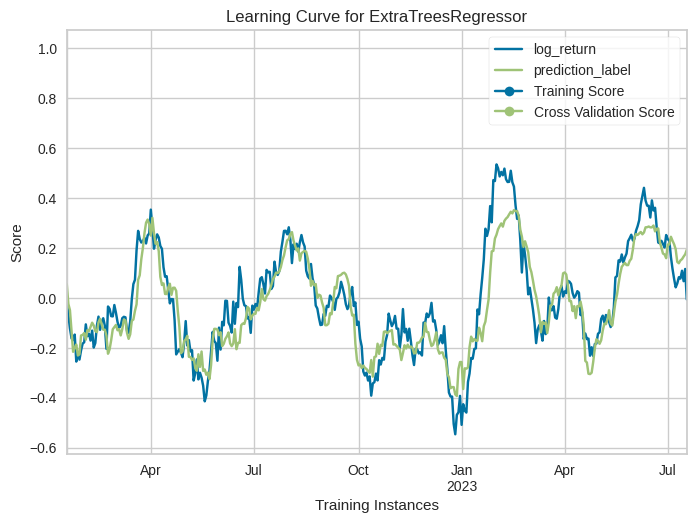

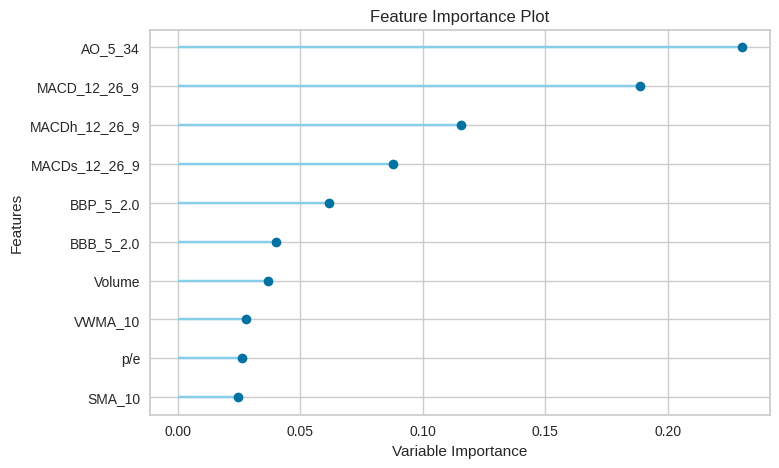




******************************
******************************
******************************
Modeling with  60 - Day Return


,Description,Value
0,Session id,42
1,Target,log_return
2,Target type,Regression
3,Original data shape,"(1246, 20)"
4,Transformed data shape,"(1246, 20)"
5,Transformed train set shape,"(872, 20)"
6,Transformed test set shape,"(374, 20)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2122,0.0670,0.2586,0.1169,0.1592,2.3266,1.6650
ada,AdaBoost Regressor,0.2203,0.0712,0.2668,0.0588,0.1582,2.7369,0.1700
rf,Random Forest Regressor,0.2180,0.0712,0.2665,0.0578,0.1591,2.6021,0.3250
et,Extra Trees Regressor,0.2216,0.0715,0.2672,0.0548,0.1517,2.8255,0.2500
gbr,Gradient Boosting Regressor,0.2276,0.0746,0.2719,0.0184,0.1625,2.5558,0.2950
dt,Decision Tree Regressor,0.2281,0.0830,0.2880,-0.0957,0.1634,2.7768,0.0450
xgboost,Extreme Gradient Boosting,0.2555,0.0945,0.3072,-0.2484,0.1847,2.7645,0.2150
dummy,Dummy Regressor,0.3665,0.1999,0.4245,-1.6142,0.2673,2.2804,0.0500
par,Passive Aggressive Regressor,0.3663,0.2004,0.4269,-1.6218,0.2730,2.2450,0.0400
omp,Orthogonal Matching Pursuit,0.3976,0.2474,0.4614,-2.2308,0.2504,2.1750,0.0400


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.1979,0.0648,0.2545,0.3466,0.1839,2.7967


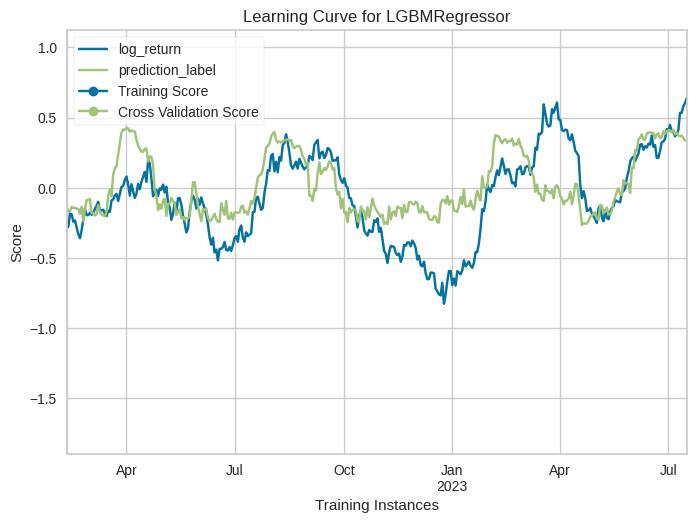

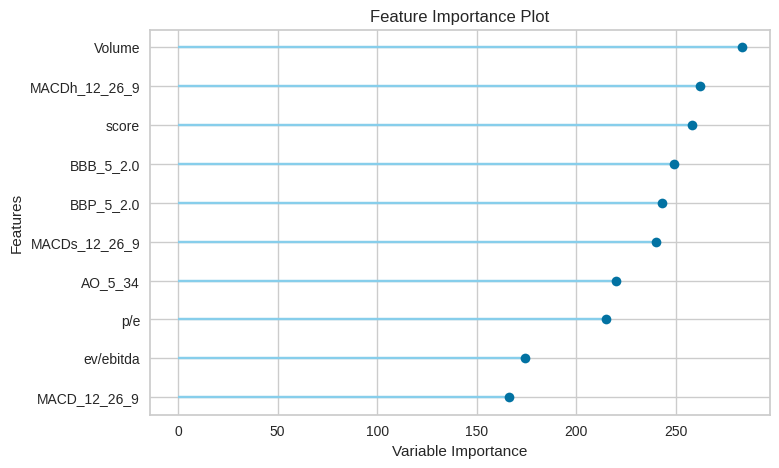

In [ ]:
import pycaret
from pycaret.time_series import TSForecastingExperiment
from pycaret.regression import RegressionExperiment

num_list = [1,5,20,60] # different periods of the return

for pct_change_days in num_list:

  #### Making 1-day ~ 60-day return as the label

  final_df['log_return'] = np.log(final_df['Close']) - np.log(final_df['Close'].shift(pct_change_days))
  final_df['log_return'] = final_df['log_return'].shift(-1)

  final_df = final_df.dropna()
  final_df= final_df.asfreq('B')
  final_df = final_df.ffill()

  exp_df = final_df[final_df.columns.difference(['Open', 'High', 'Low', 'Close'])]

  print(''* 30)
  print(''* 30)
  print(''* 30)
  print('*' * 30)
  print('*' * 30)
  print('*' * 30)

  print('Modeling with ',pct_change_days, '- Day Return')

  s = RegressionExperiment()
  s.setup(data = exp_df,
            target = 'log_return', fold_strategy = 'timeseries',
            data_split_shuffle = False,
            fold = 2, session_id = 42)

  best2 = s.compare_models()
  pred2 = s.predict_model(best2)
  result2 = s.pull()

  pred2[['log_return', 'prediction_label']].plot()
  s.plot_model(best2, plot = 'learning')

  if pct_change_days != 1:
    s.plot_model(best2, plot = 'feature')